## Code

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import glob

%matplotlib inline
import matplotlib.pyplot as plt

##Import E.g. Keras, scikit-learn
from itertools import chain
from random import sample
from collections import Counter
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Lambda
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.optimizers import Adam
import sklearn.model_selection as skl


## Do some early processing the metadata for easier model training:

In [2]:
all_xray_df = pd.read_csv('Data_Entry_2017.csv')
all_image_paths = glob.glob("data/images*/*/*")
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_image_paths
print(all_xray_df.columns)
all_xray_df.sample(5)

Scans found: 112120 , Total Headers 112120
Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path'],
      dtype='object')


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
62908,00015556_016.png,Effusion|Pleural_Thickening,16,15556,56,M,AP,2500,2048,0.168,0.168,NaN,data\images_007\images\00015556_016.png
89743,00022283_027.png,No Finding,27,22283,61,F,AP,3056,2544,0.139,0.139,NaN,data\images_010\images\00022283_027.png
7986,00002090_004.png,Pneumothorax,4,2090,46,M,AP,2500,2048,0.168,0.168,NaN,data\images_002\images\00002090_004.png
38856,00010146_006.png,No Finding,6,10146,26,F,AP,2500,2048,0.168,0.168,NaN,data\images_005\images\00010146_006.png
50663,00012834_068.png,Edema|Effusion,68,12834,33,M,AP,2500,2048,0.168,0.168,NaN,data\images_006\images\00012834_068.png


In [3]:
## Create some extra columns in your table with binary indicators of certain diseases 
df = all_xray_df.copy()
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x) > 0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    # leave out empty labels
    if len(c_label)>1:
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.sample(5)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
17993,00004832_012.png,Consolidation|Edema,12,4832,30,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107172,00028913_002.png,Effusion|Mass|Nodule,2,28913,21,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
68685,00016954_007.png,No Finding,7,16954,33,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
100505,00026657_000.png,Effusion,0,26657,57,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
44931,00011552_000.png,No Finding,0,11552,60,M,PA,2914,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
df['pneumonia_class'] = np.where(df['Pneumonia'] == 1, 'With_Pneumonia', 'Without_Pneumonia')
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Without_Pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Without_Pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Without_Pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Without_Pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Without_Pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,With_Pneumonia
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Without_Pneumonia
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Without_Pneumonia
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Without_Pneumonia


## Create your training and testing data:

In [5]:
def create_splits(df, test_size, classToPredict):
    
    ## split original dataframe into two sets 
    ## that can be used for training and testing your model
    
    train_data, val_data = train_test_split(df,  test_size = test_size, stratify = df[classToPredict])
    return train_data, val_data    

In [6]:
train_df, val_df = create_splits(df, 0.2, 'Pneumonia')

print("train_df", train_df.shape)
print("val_df", val_df.shape)

train_df (89696, 29)
val_df (22424, 29)


In [7]:
print("train", train_df['Pneumonia'].sum()/len(train_df))
print("validation", val_df['Pneumonia'].sum()/len(val_df))

train 0.012765340706386016
validation 0.012754191937210132


In [8]:
# Get a balanced dataset (50/50) = equal amount of positive and negative cases in Training
p_inds = train_df[train_df.Pneumonia==1].index.tolist()
np_inds = train_df[train_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]
print("train", train_df['Pneumonia'].sum()/len(train_df))

train 0.5


In [9]:
# Get a validation set with at 20% Pneumonia cases
p_inds = val_df[val_df.Pneumonia==1].index.tolist()
np_inds = val_df[val_df.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
val_df = val_df.loc[p_inds + np_sample]
print("validation", val_df['Pneumonia'].sum()/len(val_df))

validation 0.2


In [10]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Model-building & training

#### Perform image augmentation

In [27]:
def my_image_augmentation():
    
    ## Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    my_idg = ImageDataGenerator(rescale = 1 / 255.0,
                             horizontal_flip = True, 
                             vertical_flip = False, 
                             height_shift_range = 0.1, 
                             width_shift_range = 0.1, 
                             rotation_range = 25, 
                             shear_range = 0.1,
                             zoom_range = 0.15)    
    return my_idg


def make_train_gen(my_idg, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for training data
    ## Use the flow_from_dataframe library:
    
    train_gen = my_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'Pneumonia',
                                          class_mode = 'raw',
                                          target_size = IMG_SIZE, 
                                          batch_size = BATCH_SIZE
                                          )

    return train_gen


def make_val_gen(vargs):
    val_idg = ImageDataGenerator(rescale=1. / 255.0)    
    val_gen = val_idg.flow_from_dataframe(dataframe = val_df, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'Pneumonia',
                                              class_mode = 'raw',
                                              target_size = IMG_SIZE, 
                                              batch_size = 100
                                              ) 
    return val_gen

In [28]:
## Pull a single large batch of random validation data for testing after each epoch:
imageDataGenerator = my_image_augmentation()
val_gen = make_val_gen(val_df)
valX, valY = val_gen.next()

Found 1430 validated image filenames.


Found 2290 validated image filenames.


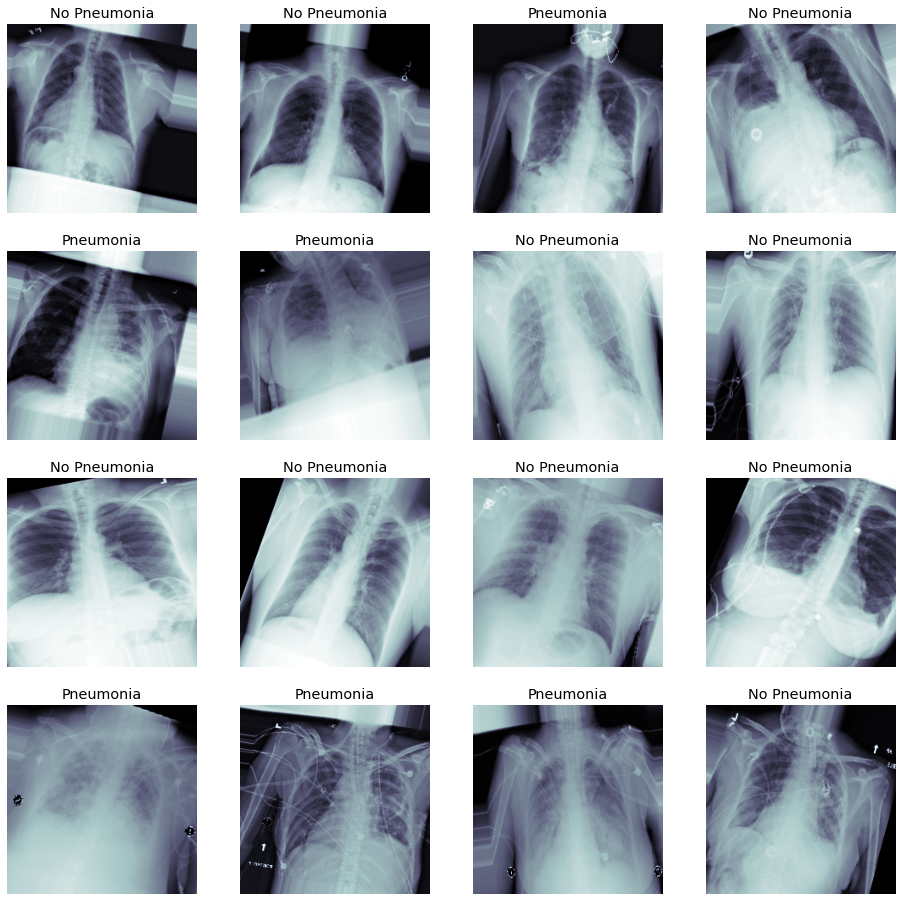

In [29]:
train_gen = make_train_gen(imageDataGenerator, train_df)

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

In [39]:
# pretrained network from Keras
def load_pretrained_model(lay_of_interest = "block5_pool"):
    
    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    return vgg_model

In [41]:
vgg_model = load_pretrained_model()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [45]:
def build_my_model():
    
    my_model = Sequential()
    # Add pre-trained model, and then whatever additional layers
    # (Flatteen, Dense, Dropout, etc.)
        
    my_model.add(load_pretrained_model())
    my_model.add(Flatten())
    my_model.add(Dropout(0.3))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.2))
    my_model.add(Dense(1, activation='sigmoid'))
    return my_model

# set number of epochs
epochs = 30
# set learning rate
learning_rate = 1e-3
# set optimiser
optimizer = Adam(lr=learning_rate)
# set loss function
loss = 'binary_crossentropy'
# set metrics
metrics = ['accuracy']

In [46]:
my_model = build_my_model()
my_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [47]:
my_model.compile(optimizer=optimizer , loss=loss, metrics=metrics)

In [48]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Training

In [49]:
## train your model
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = epochs, 
                          callbacks = callbacks_list)

C:\Users\USER\miniconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
72/72 [==============================] - 102s 1s/step - loss: 1.1011 - accuracy: 0.5341 - val_loss: 0.7748 - val_accuracy: 0.4000

Epoch 00001: val_loss improved from inf to 0.77483, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
72/72 [==============================] - 102s 1s/step - loss: 0.6958 - accuracy: 0.5228 - val_loss: 0.6482 - val_accuracy: 0.7000

Epoch 00002: val_loss improved from 0.77483 to 0.64823, saving model to xray_class_my_model.best.hdf5
Epoch 3/30
72/72 [==============================] - 103s 1s/step - loss: 0.6864 - accuracy: 0.5438 - val_loss: 0.6749 - val_accuracy: 0.6400

Epoch 00003: val_loss did not improve from 0.64823
Epoch 4/30
72/72 [==============================] - 102s 1s/step - loss: 0.6827 - accuracy: 0.5732 - val_loss: 0.6546 - val_accuracy: 0.6100

Epoch 00004: val_loss did not improve from 0.64823
Epoch 5/30
72/72 [==============================] - 103s 1s/step - loss: 0.6703 - accuracy: 0.5941 - val_loss: 0.6900 - val_accura

In [50]:
## perform prediction using the trained model
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 500, verbose = True)

1/1 [==============================] - 4s 4s/step


In [51]:
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')


def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# calculate f1
def  calc_f1(prec,recall):
    return 2*((prec*recall)/(prec+recall))
    
# plot history
def plot_history(history):
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

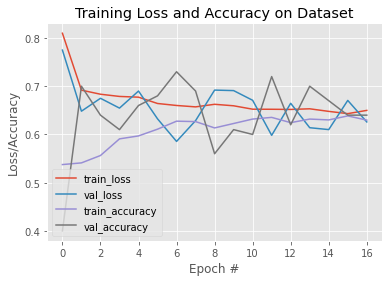

In [52]:
## plot figures
hist = plot_history(history)

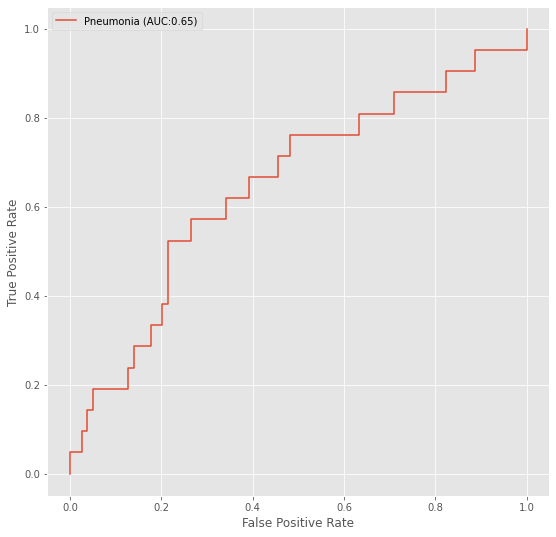

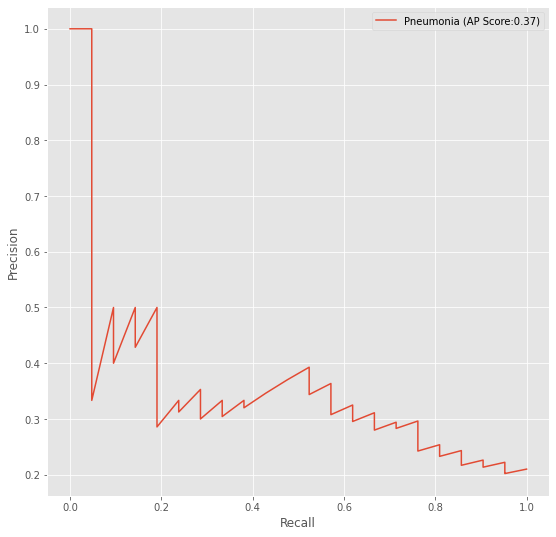

In [53]:
plot_auc(valY, pred_Y)
plot_precision_recall_curve(valY, pred_Y)

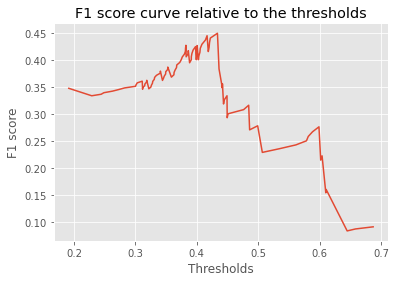

In [54]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
F1 = calc_f1(precision,recall)
F1 = np.delete(F1, -1)

plt.plot(thresholds, F1)
plt.xlabel('Thresholds')
plt.ylabel('F1 score')
plt.title('F1 score curve relative to the thresholds')
plt.show()

In [55]:
# Find threshold that optimises the model's performance and make binary classification
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]

print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

Precision: 0.39285714285714285
Recall: 0.5238095238095238
Threshold: 0.43355972
F1 Score: 0.4489795918367347


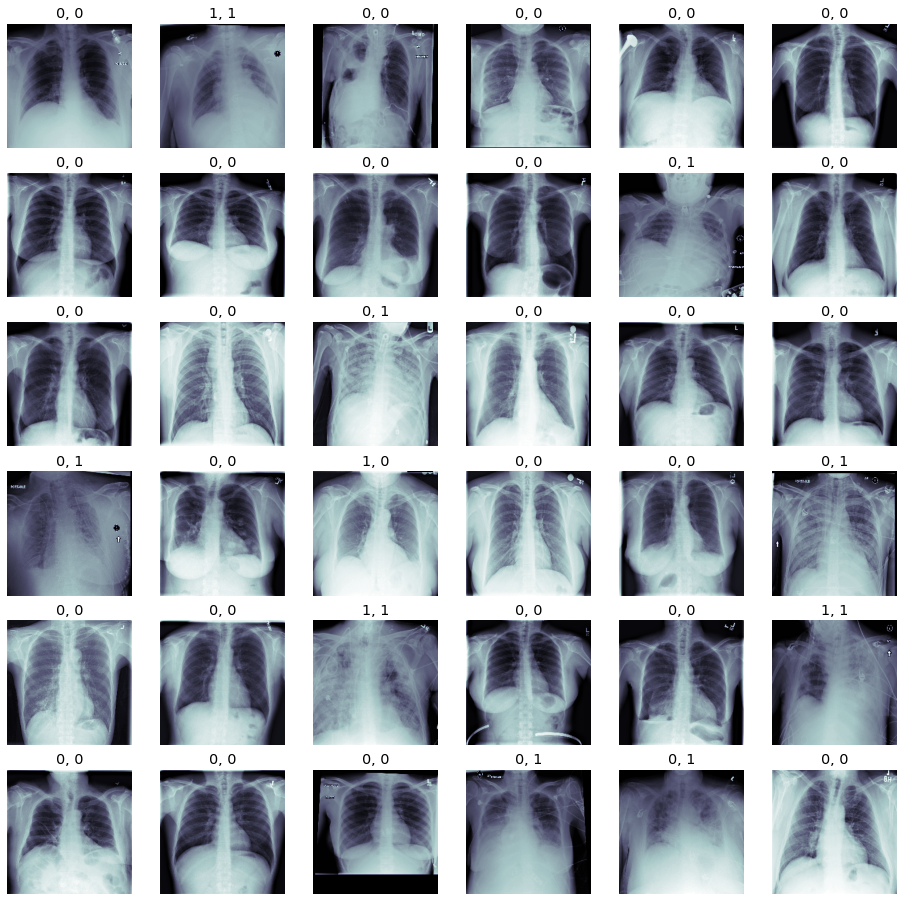

In [28]:
## Ttrue vs. Predicted with the best model: 
# select threshold = 0.43
thresholds = 0.43

fig, m_axs = plt.subplots(6, 6, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresholds:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thresholds: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [56]:
## Save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)